## Spark - Key Features

- Easy to use
  - Comes with an expressive API - 80+ operators. 
  - Different levels of abstraction - RDDs, DataFrames, SparkSQL etc.
  - API in - Java, Scala, Python, R
  - Cluster Managers - Yarn, Mezos, Spark
- Fast
  - In-memory cluster computing capabilities
  - Application can cache the data in memory - subsequent operations are performed on the cached data.
  - Advanced job execution engine 
    - job converted to DAG of stages.
    - job can contain several stages
    - stage execution - optimized to minimize data movement
- General Purpose
  - batch processing
  - interactive analysis
  - stream processing
  - machine learning
  - graph computing
- Scallable
  - just add new nodes to the cluster
- Fault tolerant
  - 100+ node cluster high chance of failure
  - Automatic node failure handling
  - Failed tasks are automatically re-executed on different node

## High Level Architecture

Terms:
- Shuffle
  - Redistributes data between the nodes.
  - Expensive
  - Not random - groups data on criteria into bucket
  - each bucket - partition
- Job
  - An execution of a data processing algorithm.
- Stage
  - A collection of tasks in shuffle boundaries
  - Tasks without shuffle - stage
  - Tasks that require shuffle, start a new stage
  - Stage depend on each other.
  

Five key entities:
- Driver Program
  - an application, uses Spark library - provides code, executed on worker nodes.
  - can launch one or more jobs on the cluster.
- Cluster Manager
  - manages resources accross the cluster
  - used to acquire resources for executing a job
- Workers
  - provide CPU, memory, storage resources to the application
- Executors
  - JVM processes created by Spark on each worker for an application
  - lifetime as an application
  - executes app code concurrently in multiple threads
  - can cache data in memory or on disk
- Tasks
  - smallest unit of work sent to an executor.
  - executed by a thread in an executor
  - returns result to driver or provides data partition for shuffle
  - task created per data pertition

## Spark Libraries
- Spark Core
- SparkSQL - SQL-like queries, DataFrame API
  - Hive, Avro, Parquet, JSON, CSV, etc.
  - Can combine data from different sources
- SparkStreaming
  - Ingest data from various sources at high velocity
- Spark MLlib - Machine learning
- GraphX - API for graph computing

## Application Core API

- SparkContext
  - Main entry point into the spark library
  - Created by the application, using configuraiton.
  - Single SparkContext per application
- Resilient Distributed Dataset (RDD)
  - Core data abstraction
  - Immutable
  - Parititioned
  - Fault tolerant
      - automatic failure handling
      - Spark reconstructs lost partitions on another node.
      - Spark stores lineage information for RDD - can reconstruct each part or entire RDD
  - Abstract Programming Interface - independent from the underlying data provider - Hbase, Cassandra, JSON, Hadoop etc.

## Spark Programming Model
- Create RDD
  - textFile()
  - parallelize()
  - wholeTextFiles()
      - key is the file path
      - value is the file content
  - sequenceFile() 
      - hadoop binary key-value file
- Functional Programming
- Create RDD
- Transformations 
  - applied to an RDD, creates another RDD
- Actions
  - return value to the driver program
- Save RDD
- 


## Practice 1
Environment:
- Cloudera CDH 5.7.0 Quick Start VM, running on Virtual Box 5.0 in Windows
- Python 3
- Jupyter Notebook (Could also use Apache Zeppelin – still in baby stage)
- Apache Spark 2.0.1 for Hadoop 2.7 


In [1]:
# Configuration

# Local dataset directory
datasets_local = 'data'

# Hadoop HDFS url
datasets_hdfs = 'hdfs://localhost:8020/user/cloudera/datasets'


# -------------------------------------
datasets = datasets_local
ml_used = 'ml-latest'    # Which MovieLens dataset to use
ml_datasets = datasets + '/' + ml_used

## Example 1. Wordcount

Let's start with a classical wordcount example. We will use direct list of lines.

In [2]:
# Create lines RDD using direct list of lines and the parallelize() method from SparkContext
rdd_lines = sc.parallelize(['Down, down, down. There was nothing else to do,','so Alice soon began talking again.'])

In [3]:
# Let's examine our lines RDD
rdd_lines.collect()

['Down, down, down. There was nothing else to do,',
 'so Alice soon began talking again.']

In [4]:
# We see that some cleaning work is to be done.
# Let's replace the dots, commas and dashes with spaces.
rdd_clean_liness = rdd_lines.map(lambda txt: txt.replace(',', ' ').replace('.', ' ').replace('-', ' ').lower())

In [5]:
# And check the result
rdd_clean_liness.collect()

['down  down  down  there was nothing else to do ',
 'so alice soon began talking again ']

In [6]:
# Now we can split the lines into individual words, using flatMap.
# flatMap can produce multiple records from a single input record.
rdd_words = rdd_clean_liness.flatMap(lambda txt: txt.split())

In [7]:
# How the words RDD looks?
rdd_words.collect()

['down',
 'down',
 'down',
 'there',
 'was',
 'nothing',
 'else',
 'to',
 'do',
 'so',
 'alice',
 'soon',
 'began',
 'talking',
 'again']

In [8]:
# And finally our counts - as a dictionary
word_counts = rdd_words.countByValue()
word_counts

defaultdict(int,
            {'again': 1,
             'alice': 1,
             'began': 1,
             'do': 1,
             'down': 3,
             'else': 1,
             'nothing': 1,
             'so': 1,
             'soon': 1,
             'talking': 1,
             'there': 1,
             'to': 1,
             'was': 1})

In [9]:
# If we want to sort the counts, we can use the items() method to get a list of (word, count) tuples:
word_counts.items()

dict_items([('again', 1), ('so', 1), ('was', 1), ('nothing', 1), ('to', 1), ('else', 1), ('soon', 1), ('do', 1), ('began', 1), ('talking', 1), ('alice', 1), ('there', 1), ('down', 3)])

In [10]:
# And sort them
sorted_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)

# And maybe take only the top word.
sorted_counts[0]

('down', 3)

## Example 2. Wordcount from File

In [11]:
! head data/book-allice-wonderland.txt

ï»¿Project Gutenbergâ€™s Aliceâ€™s Adventures in Wonderland, by Lewis Carroll

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: Aliceâ€™s Adventures in Wonderland



In [12]:
import re

In [13]:
rdd_lines = sc.textFile('data/book-allice-wonderland.txt')
#rdd_words = rdd_lines.map(lambda txt: txt.replace(',', ' ').replace('.', ' ').replace('-', ' ').lower()) \
rdd_words = rdd_lines.map(lambda txt: re.sub('\W', ' ', txt).lower()) \
         .flatMap(lambda txt: txt.split())
word_counts = rdd_words.countByValue()

sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:5]

[('the', 1818), ('and', 940), ('to', 809), ('a', 690), ('of', 631)]

In [14]:
!mkdir out

A subdirectory or file out already exists.


In [15]:
rdd_counts = sc.parallelize(word_counts.items())

In [16]:
! rm -rf out/counts

In [17]:
rdd_counts.saveAsTextFile('out/counts')

In [18]:
!ls -al out/counts

total 93
drwxrwxrwx   1 baobab          baobab                0 Nov 27 18:20 .
drwxrwxrwx   1 baobab          baobab                0 Nov 27 18:20 ..
-rwxrwxrwa   1 baobab          baobab                8 Nov 27 18:20 ._SUCCESS.crc
-rwxrwxrwa   1 baobab          baobab               96 Nov 27 18:20 .part-00000.crc
-rwxrwxrwa   1 baobab          baobab               96 Nov 27 18:20 .part-00001.crc
-rwxrwxrwa   1 baobab          baobab               96 Nov 27 18:20 .part-00002.crc
-rwxrwxrwa   1 baobab          baobab               96 Nov 27 18:20 .part-00003.crc
-rwxrwxrwa   1 baobab          baobab                0 Nov 27 18:20 _SUCCESS
-rwxrwxrwa   1 baobab          baobab            11030 Nov 27 18:20 part-00000
-rwxrwxrwa   1 baobab          baobab            10996 Nov 27 18:20 part-00001
-rwxrwxrwa   1 baobab          baobab            10918 Nov 27 18:20 part-00002
-rwxrwxrwa   1 baobab          baobab            10980 Nov 27 18:20 part-00003


## Spark DataFrame API

Sprark DataFrame API builds on the core RDD API, by providing rich and familiar set of operations.
The DataFrame API and the SparkSQL API are available through a SparkSession object.

## Example 3 - DataFrame and JSON

For this example we are going to zip code data. It is in JSON format.

In [19]:
# We can create a DataFrame by reading from a data source.
df_zips = spark.read.json(datasets + '/zips.json')
type(df_zips)

pyspark.sql.dataframe.DataFrame

In [20]:
# Print the first 5 rows to the console
df_zips.show(5)

+-----+-----------+--------------------+-----+-----+
|  _id|       city|                 loc|  pop|state|
+-----+-----------+--------------------+-----+-----+
|01001|     AGAWAM|[-72.622739, 42.0...|15338|   MA|
|01002|    CUSHMAN|[-72.51565, 42.37...|36963|   MA|
|01005|      BARRE|[-72.108354, 42.4...| 4546|   MA|
|01007|BELCHERTOWN|[-72.410953, 42.2...|10579|   MA|
|01008|  BLANDFORD|[-72.936114, 42.1...| 1240|   MA|
+-----+-----------+--------------------+-----+-----+
only showing top 5 rows



In [21]:
# We can get some summary statistics about numeric data, using describe()
df_zips.describe().show()

+-------+------------------+
|summary|               pop|
+-------+------------------+
|  count|             29353|
|   mean| 8462.794262937348|
| stddev|12329.680305853608|
|    min|                 0|
|    max|            112047|
+-------+------------------+



In [22]:
df_zips[['state']].distinct().show(5)

+-----+
|state|
+-----+
|   SC|
|   AZ|
|   LA|
|   MN|
|   NJ|
+-----+
only showing top 5 rows



In [23]:
import pyspark.sql.functions as sf

# How many people make the entire population in US according to our data?
df_zips.agg(sf.sum('pop')).show()

+---------+
| sum(pop)|
+---------+
|248408400|
+---------+



In [24]:
# Which are the 5 most populated states?
df_states = df_zips.groupBy('state').agg(sf.sum('pop').alias('pop')).orderBy(sf.desc('pop'))
df_states.take(5)

[Row(state='CA', pop=29754890),
 Row(state='NY', pop=17990402),
 Row(state='TX', pop=16984601),
 Row(state='FL', pop=12686644),
 Row(state='PA', pop=11881643)]

In [25]:
### Let's do some charting

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [27]:
pd_states = df_states.toPandas()
pd_states['pop'] = (pd_states['pop']/1000).astype('int')
pd_states.head(5)

,state,pop
0,CA,29754
1,NY,17990
2,TX,16984
3,FL,12686
4,PA,11881


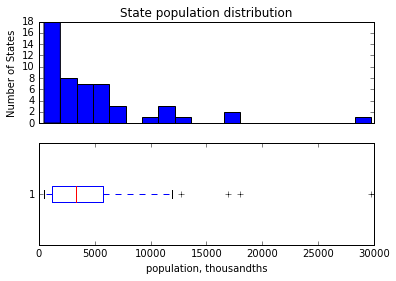

In [28]:
plt.subplot(211)
plt.gca().get_xaxis().set_visible(False)
plt.title('State population distribution')
plt.ylabel('Number of States')
plt.hist(pd_states['pop'], bins=20)
plt.subplot(212)
plt.boxplot(pd_states['pop'], vert=False)
plt.xlabel('population, thousandths')
plt.show()

In [29]:
df_states.orderBy('pop', ascending = True).show(5)

+-----+------+
|state|   pop|
+-----+------+
|   WY|453528|
|   AK|544698|
|   VT|562758|
|   DC|606900|
|   ND|638272|
+-----+------+
only showing top 5 rows



## MovieLens Dataset

In our examples we are using a popular MovieLens dataset.

### Download MovieLens dataset
Because the filesize is big (>150 MB compressed) we are going to download the files from the GorupLens web site.


In [11]:
import pandas as pd
import glob
import os.path
import os
from urllib.request import urlopen

In [19]:
def install_ml_dataset(dataset_name):
    # Download
    zip_filename = datasets_local + '/' + dataset_name + '.zip'
    dataset_dir = datasets_local  + '/' + dataset_name
    if os.path.exists(dataset_dir):
        print('Dataset exists.')
        return
    print('Dataset directory not found. Will try to install it.')
    if os.path.exists(zip_filename):
        print('File %s found. Going to use it.' % zip_filename)
    else:
        url = 'http://files.grouplens.org/datasets/movielens/' + dataset_name + '.zip'
        print('File %s doesn exists. Going to download from %s' % (zip_filename, url) )
        print("Might take a while. Please be patient...")
        with urlopen(url) as infile:
            data = infile.read()
        with open(zip_filename, 'wb') as outfile:
            outfile.write(data)
        print("Download complete. Saved %d bytes." % os.path.getsize(zip_filename))
    
    unzip_command = 'unzip %s -d %s' % (zip_filename, datasets_local)
    print('Extract using command: \n%s' % (unzip_command))
    if os.system(unzip_command):
        raise Exception('Unable to extract file. Please try to execute manually.')
    else:
        print("Dataset installed successfully.")
    
    
install_ml_dataset(ml_used)

Dataset exists.


### Study the MovieLens dataset files

In [31]:
# What files we have in our MovieLens dataset
! ls $datasets_local/$ml_used

README.txt
genome-scores.csv
genome-tags.csv
links.csv
movies.csv
parquet
ratings.csv
tags.csv


In [32]:
# Let's collect some summary info into Python

In [33]:
%%time
# We will measure the cell execution time using the IPython's time magic
data_info = []


# For each CSV file in our local MovieLens dataset
#   - get the data name
#   - get the filesize
#   - load the CSV and get the number of records
for csv_filename in glob.glob(datasets_local + '/' + ml_used + '/*.csv'):
    name = os.path.basename(csv_filename)[:-4]
    file_size = os.path.getsize(csv_filename)
    ds = spark.read.csv(csv_filename, header=True, inferSchema=True)
    rec_count = ds.count()
    data_info.append( (csv_filename, name, file_size, rec_count) )

Wall time: 51.3 s


In [34]:
# Create pandas DataFrame
df_ml = pd.DataFrame(data_info, columns=['filename', 'name','file_size', 'record_count'])

In [17]:
# We could use the humanize (https://pypi.python.org/pypi/humanize) Python package, but 
# is not a big deal to create a custom function.
def sizeof_fmt(num, fmt="%0.1f %s%s", multiplier=1024.0, units=None, suffix='B'):
    # Handle optional arguments
    multiplier = float(multiplier)
    if not units:
        units = ['','K','M','G','T','P','E','Z','Y']
        
    for unit in units[:-1]:
        if abs(num) < multiplier:
            return fmt % (num, unit, suffix)
        num /= multiplier
    return fmt % (num, units[-1], suffix)

In [20]:
# Let's test our fomratting function
print(sizeof_fmt(123))
print(sizeof_fmt(1234))
print(sizeof_fmt(1234567))
print(sizeof_fmt(1234567890))
print(sizeof_fmt(1234567890123))
print(sizeof_fmt(1234567890123456))
print(sizeof_fmt(1234567890123456789))
print(sizeof_fmt(1234567890123456789012))
print(sizeof_fmt(1234567890123456789012345))
print(sizeof_fmt(1234567890123456789012345678, fmt='%0.3f %s%s'))
print(sizeof_fmt(1234567890123456789012345678, fmt='%0d %s%s'))

123.0 B
1.2 KB
1.2 MB
1.1 GB
1.1 TB
1.1 PB
1.1 EB
1.0 ZB
1.0 YB
1021.211 YB
1021 YB


In [37]:
# A little humanization
df_ml['File Size'] = df_ml['file_size'].map(sizeof_fmt)
df_ml['Num Records'] = df_ml['record_count'].map(lambda x: sizeof_fmt(x, suffix=''))
df_ml[df_ml.columns[1:]]   # Skip the filename column. Could be long and is not interesting here.


,name,file_size,record_count,File Size,Num Records
0,genome-scores,333365341,12040272,317.9 MB,11.5 M
1,genome-tags,18103,1128,17.7 KB,1.1 K
2,links,859311,40110,839.2 KB,39.2 K
3,movies,2007982,40110,1.9 MB,39.2 K
4,ratings,663420664,24404096,632.7 MB,23.3 M
5,tags,24032991,668953,22.9 MB,653.3 K


## Example 4. Parquet files

Spark supports various input formats out of the box. One of the popular file formats is Parquet. Parquet is a columnar file format with RLE. Let's compare the performance of csv and parquet files.

We are going to use the popular MovieLens dataset - collected information about movie ratings from visitors.

The Movielens dataset is in two sizes: small and full. The small dataset presents a 10% movie sample over the full dataset We are going to use the **full size** just to demonstrate the power and speed of Spark.

#### Create Parquet files from CSV

We are going to convert our MovieLens dataset files into Parquet files.

In [38]:
%%time

for file_index in df_ml.index:
    file_info = df_ml.iloc[file_index]

    # Read the CSV file
    df = spark.read.csv(file_info['filename'], header=True, inferSchema=True)
    
    # Save Parquet format
    df.write.parquet(ml_datasets + '/parquet/' + file_info['name'])


Wall time: 1min 7s


In [39]:
# What is the total disk usage for Parqute files?
! du -h $ml_datasets/parquet

   18.81MB data/ml-latest/parquet/genome-scores
   17.00KB data/ml-latest/parquet/genome-tags
  476.00KB data/ml-latest/parquet/links
    1.02MB data/ml-latest/parquet/movies
  144.10MB data/ml-latest/parquet/ratings
    6.99MB data/ml-latest/parquet/tags
  171.40MB data/ml-latest/parquet


In [40]:
# What is the total usage for CSV files?
sizeof_fmt(sum(df_ml['file_size']))

'976.3 MB'

#### Compare Parquet vs CSV performance

In [41]:
# We are going to use the embedded timeit IPython magic.
# Let's see its documentation.

%%timeit?

In [42]:
%%timeit -n 1 -r 2
spark.read.csv(ml_datasets + '/ratings.csv', header=True, inferSchema=True).count()

1 loop, best of 2: 26.3 s per loop


In [43]:
%%timeit -n 2 -r 1
spark.read.parquet(ml_datasets + '/parquet/ratings').count()

2 loops, best of 1: 422 ms per loop


## Example 5 - Explore MovieLens with Spark DataFrame

In [44]:
df_rating = spark.read.parquet(ml_datasets + '/parquet/ratings')

In [45]:
df_rating.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|    122|   2.0|945544824|
|     1|    172|   1.0|945544871|
|     1|   1221|   5.0|945544788|
|     1|   1441|   4.0|945544871|
|     1|   1609|   3.0|945544824|
+------+-------+------+---------+
only showing top 5 rows



In [46]:
# How many ratings do we have?
df_rating.count()

24404096

In [47]:
# Fields have type
df_rating.schema

StructType(List(StructField(userId,IntegerType,true),StructField(movieId,IntegerType,true),StructField(rating,DoubleType,true),StructField(timestamp,IntegerType,true)))

In [48]:
# I want to know how many movies have rating 3
df_rating_3 = df_rating.filter('rating = 3')

df_rating_3.count()

5011914

In [49]:
# Let's see some of the movies with rating 3

df_movies = spark.read.parquet(ml_datasets + '/parquet/movies')

In [50]:
df_movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



**Join movies and ratings**

In [51]:
%%time
df_rating_3.join(df_movies, on='movieId').show(5)

+-------+------+------+----------+--------------------+--------------------+
|movieId|userId|rating| timestamp|               title|              genres|
+-------+------+------+----------+--------------------+--------------------+
|   1609|     1|   3.0| 945544824|187 (One Eight Se...|      Drama|Thriller|
|   1961|     1|   3.0| 945544871|     Rain Man (1988)|               Drama|
|   1597|     2|   3.0|1008942773|Conspiracy Theory...|Drama|Mystery|Rom...|
|   1608|     2|   3.0|1008942733|Air Force One (1997)|     Action|Thriller|
|   4963|     2|   3.0|1008942667|Ocean's Eleven (2...|      Crime|Thriller|
+-------+------+------+----------+--------------------+--------------------+
only showing top 5 rows

Wall time: 938 ms


## Practice II

## Explore SparkSQL

In [52]:
# Load source files into DataFrames
df_movies = spark.read.parquet(ml_datasets + '/parquet/movies')
df_ratings = spark.read.parquet(ml_datasets + '/parquet/ratings')
df_tags = spark.read.parquet(ml_datasets + '/parquet/genome-tags')
df_scores = spark.read.parquet(ml_datasets + '/parquet/genome-scores')


In [53]:
df_movies.createOrReplaceTempView('movies')
df_ratings.createOrReplaceTempView('ratings')
df_tags.createOrReplaceTempView('gtags')
df_scores.createOrReplaceTempView('gscores')

In [54]:
df_movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [55]:
df_scores.show(5)

+-------+-----+-------------------+
|movieId|tagId|          relevance|
+-------+-----+-------------------+
|      1|    1|0.02400000000000002|
|      1|    2|0.02400000000000002|
|      1|    3|0.05475000000000002|
|      1|    4|0.09200000000000003|
|      1|    5|            0.14825|
+-------+-----+-------------------+
only showing top 5 rows



In [56]:
df_tags.show(5)

+-----+------------+
|tagId|         tag|
+-----+------------+
|    1|         007|
|    2|007 (series)|
|    3|18th century|
|    4|       1920s|
|    5|       1930s|
+-----+------------+
only showing top 5 rows



In [57]:
spark.sql("SELECT * FROM movies WHERE title LIKE 'Shrek%'").show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|   4306|        Shrek (2001)|Adventure|Animati...|
|   8360|      Shrek 2 (2004)|Adventure|Animati...|
|  53121|Shrek the Third (...|Adventure|Animati...|
|  64249|Shrek the Halls (...|Adventure|Animati...|
|  78637|Shrek Forever Aft...|Adventure|Animati...|
| 109965|Shrek the Musical...|Children|Comedy|F...|
+-------+--------------------+--------------------+



In [58]:
shrek_tags = spark.sql("SELECT gs.movieId, gs.tagId, gs.relevance, gt.tag FROM gscores gs JOIN gtags gt ON gs.tagId=gt.tagId WHERE movieId=4306")
shrek_tags.show()

+-------+-----+--------------------+---------------+
|movieId|tagId|           relevance|            tag|
+-------+-----+--------------------+---------------+
|   4306|    1| 0.03149999999999997|            007|
|   4306|    2|0.028749999999999998|   007 (series)|
|   4306|    3|0.035999999999999976|   18th century|
|   4306|    4|0.058750000000000024|          1920s|
|   4306|    5| 0.12674999999999997|          1930s|
|   4306|    6| 0.09200000000000003|          1950s|
|   4306|    7| 0.02400000000000002|          1960s|
|   4306|    8|               0.182|          1970s|
|   4306|    9|             0.09025|          1980s|
|   4306|   10| 0.04149999999999998|   19th century|
|   4306|   11|              0.2855|             3d|
|   4306|   12|0.057499999999999996|           70mm|
|   4306|   13| 0.06624999999999998|            80s|
|   4306|   14|0.012749999999999984|           9/11|
|   4306|   15|             0.03075|        aardman|
|   4306|   16|              0.2375|aardman st

In [59]:
shrek_tags.explain()

== Physical Plan ==
*Project [movieId#545, tagId#546, relevance#547, tag#541]
+- *BroadcastHashJoin [tagId#546], [tagId#540], Inner, BuildRight
   :- *Project [movieId#545, tagId#546, relevance#547]
   :  +- *Filter ((isnotnull(movieId#545) && (movieId#545 = 4306)) && isnotnull(tagId#546))
   :     +- *BatchedScan parquet [movieId#545,tagId#546,relevance#547] Format: ParquetFormat, InputPaths: file:/D:/Sandbox/spark-intro/git/spark-intro/data/ml-latest/parquet/genome-scores, PartitionFilters: [], PushedFilters: [IsNotNull(movieId), EqualTo(movieId,4306), IsNotNull(tagId)], ReadSchema: struct<movieId:int,tagId:int,relevance:double>
   +- BroadcastExchange HashedRelationBroadcastMode(List(cast(input[0, int, true] as bigint)))
      +- *Project [tagId#540, tag#541]
         +- *Filter isnotnull(tagId#540)
            +- *BatchedScan parquet [tagId#540,tag#541] Format: ParquetFormat, InputPaths: file:/D:/Sandbox/spark-intro/git/spark-intro/data/ml-latest/parquet/genome-tags, PartitionFilte

In [60]:
shrek_tags.createOrReplaceTempView('shrek_tags')

In [61]:
df_relevant = spark.sql("""
    SELECT gs.movieId,
           m.title,
           gs.tagId,
           gs.relevance,
           t.tag
      FROM gscores gs
      JOIN shrek_tags ss ON ss.tagId=gs.tagId AND ss.movieId=4306
      JOIN movies m ON m.movieId=gs.movieId
      JOIN gtags t ON t.tagId=gs.tagId
    """)

In [62]:
df_relevant.show(10)

+-------+--------------------+-----+--------------------+----+
|movieId|               title|tagId|           relevance| tag|
+-------+--------------------+-----+--------------------+----+
|      1|    Toy Story (1995)|  148| 0.02200000000000002|boat|
|      2|      Jumanji (1995)|  148| 0.02300000000000002|boat|
|      3|Grumpier Old Men ...|  148| 0.09200000000000003|boat|
|      4|Waiting to Exhale...|  148| 0.03149999999999997|boat|
|      5|Father of the Bri...|  148|0.060250000000000026|boat|
|      6|         Heat (1995)|  148| 0.02024999999999999|boat|
|      7|      Sabrina (1995)|  148|0.056999999999999995|boat|
|      8| Tom and Huck (1995)|  148| 0.04325000000000001|boat|
|      9| Sudden Death (1995)|  148|0.020000000000000018|boat|
|     10|    GoldenEye (1995)|  148|             0.09425|boat|
+-------+--------------------+-----+--------------------+----+
only showing top 10 rows



In [63]:
df_relevant_improve = spark.sql("""
    SELECT gs.movieId,
           m.title,
           gs.tagId,
           gs.relevance,
           t.tag,
           ss.relevance AS shrek_relevance
      FROM gscores gs
      JOIN shrek_tags ss ON ss.tagId=gs.tagId AND ss.movieId=4306 AND ss.relevance > 0.8
      JOIN movies m ON m.movieId=gs.movieId
      JOIN gtags t ON t.tagId=gs.tagId
     WHERE gs.relevance > 0.8
    """)

In [64]:
df_relevant_improve.show(10)

+-------+--------------------+-----+------------------+----+---------------+
|movieId|               title|tagId|         relevance| tag|shrek_relevance|
+-------+--------------------+-----+------------------+----+---------------+
|      1|    Toy Story (1995)|  588|           0.97875|kids|         0.9595|
|      2|      Jumanji (1995)|  588|             0.958|kids|         0.9595|
|     54|Big Green, The (1...|  588|           0.93025|kids|         0.9595|
|     56|Kids of the Round...|  588|0.9652499999999999|kids|         0.9595|
|     87|Dunston Checks In...|  588|            0.8225|kids|         0.9595|
|    146|Amazing Panda Adv...|  588|0.8614999999999999|kids|         0.9595|
|    158|       Casper (1995)|  588|0.9312499999999999|kids|         0.9595|
|    239|Goofy Movie, A (1...|  588|0.8402499999999999|kids|         0.9595|
|    250|Heavyweights (Hea...|  588|0.8799999999999999|kids|         0.9595|
|    258|Kid in King Arthu...|  588|           0.84425|kids|         0.9595|

In [65]:
df_relevant_improve.cache().createOrReplaceTempView('relevant')

In [66]:
spark.sql('SELECT AVG(relevance) AS rel, movieId, title FROM relevant GROUP BY movieId, title ORDER BY rel DESC').show(10)

+------------------+-------+--------------------+
|               rel|movieId|               title|
+------------------+-------+--------------------+
|            0.9935|   5419|   Scooby-Doo (2002)|
|           0.98875|   2147|Clan of the Cave ...|
|0.9882500000000001|   3435|Double Indemnity ...|
|0.9877499999999999|  91500|The Hunger Games ...|
|0.9877499999999999|   1178|Paths of Glory (1...|
|             0.986| 118997|Into the Woods (2...|
|           0.98525|  63239|   Cinderella (1997)|
|0.9850000000000001|   1212|Third Man, The (1...|
|0.9850000000000001|   4298|Rififi (Du rififi...|
|           0.98475|  59615|Indiana Jones and...|
+------------------+-------+--------------------+
only showing top 10 rows



In [67]:
%%time
df_suggested = spark.sql('SELECT AVG(relevance) AS rel, movieId, title FROM relevant WHERE shrek_relevance > 0.9 GROUP BY movieId, title ORDER BY rel DESC')
df_suggested.show(10)

+------------------+-------+--------------------+
|               rel|movieId|               title|
+------------------+-------+--------------------+
|            0.9955|   2720|Inspector Gadget ...|
|0.9944999999999999|    905|It Happened One N...|
|             0.994|   2726| Killing, The (1956)|
|0.9937499999999999|  63540|Beverly Hills Chi...|
|            0.9935|   5419|   Scooby-Doo (2002)|
|           0.99325|   1945|On the Waterfront...|
|          0.992875|  36401|Brothers Grimm, T...|
|           0.99125|   3468| Hustler, The (1961)|
|           0.99075|    923| Citizen Kane (1941)|
|           0.99075|   1193|One Flew Over the...|
+------------------+-------+--------------------+
only showing top 10 rows

Wall time: 6.98 s


In [68]:
df_suggested.explain()

== Physical Plan ==
*Sort [rel#719 DESC], true, 0
+- Exchange rangepartitioning(rel#719 DESC, 200)
   +- *HashAggregate(keys=[movieId#545, title#525], functions=[avg(relevance#547)])
      +- Exchange hashpartitioning(movieId#545, title#525, 200)
         +- *HashAggregate(keys=[movieId#545, title#525], functions=[partial_avg(relevance#547)])
            +- *Project [movieId#545, title#525, relevance#547]
               +- *Filter (isnotnull(shrek_relevance#614) && (shrek_relevance#614 > 0.9))
                  +- InMemoryTableScan [movieId#545, title#525, relevance#547, shrek_relevance#614], [isnotnull(shrek_relevance#614), (shrek_relevance#614 > 0.9)]
                     :  +- InMemoryRelation [movieId#545, title#525, tagId#546, relevance#547, tag#630, shrek_relevance#614], true, 10000, StorageLevel(disk, memory, deserialized, 1 replicas)
                     :     :  +- *Project [movieId#545, title#525, tagId#546, relevance#547, tag#630, relevance#628 AS shrek_relevance#614]
      

## Explore Catalog

In [69]:
spark.catalog.listDatabases()

[Database(name='default', description='Default Hive database', locationUri='file:/D:/Sandbox/spark-intro/git/spark-intro/spark-warehouse')]

In [70]:
spark.catalog.listTables()

[Table(name='like_shrek', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gscores', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='gtags', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='movies', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='ratings', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='relevant', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='shrek_tags', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [71]:
# We can materialize our suggestions to a physical table
spark.sql('DROP TABLE IF EXISTS default.like_shrek')
spark.sql('CREATE TABLE default.like_shrek AS SELECT AVG(relevance) AS rel, movieId, title FROM relevant WHERE shrek_relevance > 0.9 GROUP BY movieId, title ')

DataFrame[]

In [72]:
# Now we can see our table is not temporary
spark.catalog.listTables()

[Table(name='like_shrek', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gscores', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='gtags', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='movies', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='ratings', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='relevant', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='shrek_tags', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [73]:
df_like_shrek = spark.sql('SELECT * FROM like_shrek ORDER BY rel DESC')
df_like_shrek.show(10)

+------------------+-------+--------------------+
|               rel|movieid|               title|
+------------------+-------+--------------------+
|            0.9955|   2720|Inspector Gadget ...|
|0.9944999999999999|    905|It Happened One N...|
|             0.994|   2726| Killing, The (1956)|
|0.9937499999999999|  63540|Beverly Hills Chi...|
|            0.9935|   5419|   Scooby-Doo (2002)|
|           0.99325|   1945|On the Waterfront...|
|          0.992875|  36401|Brothers Grimm, T...|
|           0.99125|   3468| Hustler, The (1961)|
|           0.99075|    923| Citizen Kane (1941)|
|           0.99075|   1193|One Flew Over the...|
+------------------+-------+--------------------+
only showing top 10 rows



In [74]:
df_like_shrek.explain()

== Physical Plan ==
*Sort [rel#898 DESC], true, 0
+- Exchange rangepartitioning(rel#898 DESC, 200)
   +- HiveTableScan [rel#898, movieid#899, title#900], MetastoreRelation default, like_shrek


In [75]:
spark.sql("SELECT * FROM relevant").explain()

== Physical Plan ==
InMemoryTableScan [movieId#545, title#525, tagId#546, relevance#547, tag#630, shrek_relevance#614]
:  +- InMemoryRelation [movieId#545, title#525, tagId#546, relevance#547, tag#630, shrek_relevance#614], true, 10000, StorageLevel(disk, memory, deserialized, 1 replicas)
:     :  +- *Project [movieId#545, title#525, tagId#546, relevance#547, tag#630, relevance#628 AS shrek_relevance#614]
:     :     +- *BroadcastHashJoin [tagId#546], [tagId#629], Inner, BuildRight
:     :        :- *Project [movieId#545, tagId#546, relevance#547, relevance#628, title#525]
:     :        :  +- *BroadcastHashJoin [movieId#545], [movieId#524], Inner, BuildRight
:     :        :     :- *Project [movieId#545, tagId#546, relevance#547, relevance#628]
:     :        :     :  +- *SortMergeJoin [tagId#546], [tagId#627], Inner
:     :        :     :     :- *Sort [tagId#546 ASC], false, 0
:     :        :     :     :  +- Exchange hashpartitioning(tagId#546, 200)
:     :        :     :     :     

## Spark Streaming

The core of Spark Streaming is the DStream (discretized stream) analogous to RDD. 
Spark collects stream data in microbatches, creating multiple RDDs. Each batch, a new DStream is produced, containing all the RDDs collected during the batch.

## Example: Real-time Word Popularity


Let's start a netcat server. The server will listen on port 9999 and will send a line from the standard input each second (`-i 1` option).

```bash
$ nc -l -p 9999 -i 1 < data/book-allice-wonderland.txt
```

**wordcount-streaming.py**

```python
import sys
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
import re

if __name__ == "__main__":

    hostname = "localhost"
    port = 9999
    
    sc = SparkContext(appName="StreamingWordCountInPython")
    
    # Necessary log4j logging level settings are done 
    log4j = sc._jvm.org.apache.log4j
    log4j.LogManager.getRootLogger().setLevel(log4j.Level.ERROR)
    
    ssc = StreamingContext(sc, 2)
    lines_ds = ssc.socketTextStream(hostname, port)
    words = lines_ds.flatMap(lambda line: re.sub('\W', ' ', line).split() )
    counts_sorted = words.countByValue()    \
              .transform(lambda rdd: rdd.sortBy(lambda x: x[1], False))
    counts_sorted.pprint()

    
    ssc.start()
    ssc.awaitTermination()
```


```bash
$ spark-submit --master=local[*] wordcount-streaming.py
```



## Window Processing

- *Batch Interval* - The time interval at which a new DStream is produced. E.g. each 10 seconds
- *Window Length* - The duration of batch intervals over which the operation is performed. E.g. messages last 5  minutes
- *Slide Interval* - The interval at which the window operation is performed. E.g. every 20 seconds

- *Block Interval*  - The duration of a micro-batch. Default is 200ms

## Example - Online Word Popularity

What if we want to monitor how the popularity of a word changes over time?
We want to see what where the most popular words in the past 5 minutes.


**wordcount-window.py**

```python
import sys
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
import re

if __name__ == "__main__":

    sc = SparkContext(appName="PythonStreamingWordCount")
    
    # Necessary log4j logging level settings are done 
    log4j = sc._jvm.org.apache.log4j
    log4j.LogManager.getRootLogger().setLevel(log4j.Level.ERROR)
    
    # Create the Spark Streaming Context with 10 seconds batch interval
    ssc = StreamingContext(sc, 10)
    
    # Set the check point directory for saving the data to recover when there is a crash
    ssc.checkpoint("checkpoint")
    
    # Create a DStream that connects to localhost on port 9999
    lines_ds = ssc.socketTextStream("localhost", 9999)
    words = lines_ds.flatMap(lambda line: re.sub('\W', ' ', line).split() )
    counts_sorted = words.countByValueAndWindow(300,10)   \
                   .transform(lambda rdd: rdd.sortBy(lambda x: x[1], False))
    counts_sorted.pprint()

    ssc.start()
    ssc.awaitTermination()

```